In [2]:
import pandas as pd
import numpy as np
import warnings
import sys
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import sys

sys.path.append("..")
# sys.path.append(".")
from tool import market_dynamics_modeling_analysis
from tool import label_util as util
from comprehensive_evaluation.analyzer import *
from comprehensive_evaluation.util import *
from comprehensive_evaluation.slice_model import *

In [39]:
positions = np.load("../data/micro_action.npy")
data = pd.read_feather("../data/test.feather")
strategy = transform_market_order_strategy(data, positions, max_holding_number=4000)

In [44]:
data.tail()

,timestamp,symbol,ask1_price,ask1_size,bid1_price,bid1_size,ask2_price,ask2_size,bid2_price,bid2_size,...,roc_60_m,beta_60_m,max_60_m,min_60_m,qtlu_60_m,qtld_60_m,imax_60_m,imin_60_m,imxd_60_m,imxd_60_dis_m
794143,2022-08-15 23:59:55,GALAUSDT,0.06704,21530.0,0.06703,28875.0,0.06705,5965.0,0.06702,162802.0,...,-0.970452,-0.016174,0.369696,-2.726508,0.009242,-2.19507,0.916667,0.083333,0.833333,1.0
794144,2022-08-15 23:59:56,GALAUSDT,0.06704,21530.0,0.06703,28875.0,0.06705,5965.0,0.06702,167709.0,...,-0.970452,-0.016174,0.369696,-2.726508,0.009242,-2.19507,0.916667,0.083333,0.833333,1.0
794145,2022-08-15 23:59:57,GALAUSDT,0.06704,21530.0,0.06703,28875.0,0.06705,5965.0,0.06702,302709.0,...,-0.970452,-0.016174,0.369696,-2.726508,0.009242,-2.19507,0.916667,0.083333,0.833333,1.0
794146,2022-08-15 23:59:58,GALAUSDT,0.06704,21424.0,0.06703,33631.0,0.06705,5965.0,0.06702,174304.0,...,-0.970452,-0.016174,0.369696,-2.726508,0.009242,-2.19507,0.916667,0.083333,0.833333,1.0
794147,2022-08-15 23:59:59,GALAUSDT,0.06708,7501.0,0.06707,10093.0,0.06709,442.0,0.06706,16767.0,...,-0.970452,-0.016174,0.369696,-2.726508,0.009242,-2.19507,0.916667,0.083333,0.833333,1.0


In [41]:
strategy

[{'timestamp': Timestamp('2022-08-06 21:26:56'),
  'action': 'buy',
  'order': [{'price': 0.06047, 'amount': 1735.0},
   {'price': 0.06048, 'amount': 2265.0}],
  'position': 4000.0},
 {'timestamp': Timestamp('2022-08-07 01:39:19'),
  'action': 'sell',
  'order': [{'price': 0.05948, 'amount': 4000.0}],
  'position': 0.0},
 {'timestamp': Timestamp('2022-08-07 01:53:25'),
  'action': 'buy',
  'order': [{'price': 0.05954, 'amount': 2000.0}],
  'position': 2000.0},
 {'timestamp': Timestamp('2022-08-07 01:54:24'),
  'action': 'sell',
  'order': [{'price': 0.05954, 'amount': 1000.0}],
  'position': 1000.0},
 {'timestamp': Timestamp('2022-08-07 01:55:11'),
  'action': 'sell',
  'order': [{'price': 0.05952, 'amount': 1000.0}],
  'position': 0.0},
 {'timestamp': Timestamp('2022-08-07 02:01:36'),
  'action': 'buy',
  'order': [{'price': 0.05953, 'amount': 1000.0}],
  'position': 1000.0},
 {'timestamp': Timestamp('2022-08-07 02:01:58'),
  'action': 'buy',
  'order': [{'price': 0.0595, 'amount': 10

### Analyzer

In [6]:
price_timing = [
    price["timestamp"] for price in strategy
]  # [Timestamp('2022-08-06 21:26:56'),numpy.datetime64('2022-08-06T22:10:52.000000000')]
print(price_timing)
assert max(price_timing) <= max(data.timestamp)
# check the price is legal
for timestamp in data.timestamp.unique():
    price_single_timestamp = data[data["timestamp"] == timestamp]

    assert (
        price_single_timestamp["ask1_price"].values[0]
        >= price_single_timestamp["bid1_price"].values[0]
    )

[Timestamp('2022-08-06 21:26:56')]


In [7]:
# check the strategy opening position is whether is over rated and place correctly
# 对于买单我们要检查他的买入价格的下限应该符合ask1 price
for stack_order in strategy:
    timestamp = stack_order["timestamp"]
    current_data = data[data["timestamp"] == timestamp]
    assert stack_order["action"] in ["buy", "sell"]
    if stack_order["action"] == "buy":
        list_order = stack_order["order"]
        level_number = len(list_order)
        for i in range(level_number):
            print(current_data["ask{}_price".format(i + 1)])

            assert (
                list_order[i]["price"]
                == current_data["ask{}_price".format(i + 1)].values[0]
            )
            assert (
                list_order[i]["amount"]
                <= current_data["ask{}_size".format(i + 1)].values[
                    0
                ]  # 买入量 <= 此时此价格待卖出总量
            )
    elif stack_order["action"] == "sell":
        list_order = stack_order["order"]
        level_number = len(list_order)
        for i in range(level_number):
            assert (
                list_order[i]["price"]
                == current_data["bid{}_price".format(i + 1)].values[0]
            )
            assert (
                list_order[i]["amount"]
                <= current_data["bid{}_size".format(i + 1)].values[0]  # 卖出量 <= 此时此价格想买入的总量
            )

7364    0.06047
Name: ask1_price, dtype: float64
7364    0.06048
Name: ask2_price, dtype: float64


In [8]:
# check the trace of the position in the trading process is legal or not. it always should be 0 at the start and end of the trading process
if strategy[-1]["position"] != 0:
    last_position = strategy[-1]["position"]
    warnings.warn(
        "the final position of the strategy is not zero, we force the agent to close its position in the last timestamp"
    )
    last_data = data[data["timestamp"] == max(data["timestamp"].unique())]
    size_sum = 0
    if (
        last_position
        > last_data["bid1_size"].values[0]
        + last_data["bid2_size"].values[0]
        + last_data["bid3_size"].values[0]
        + last_data["bid4_size"].values[0]
        + last_data["bid5_size"].values[0]
    ):
        warnings.warn(
            "we barely trade at this timstamp instantly because there is no enough liquidity in the market,\
        we force the agent to close its position in the last timestamp by expanding the last level's size"
        )
        last_data["bid5_size"] = last_position - (
            last_data["bid1_size"].values[0]
            + last_data["bid2_size"].values[0]
            + last_data["bid3_size"].values[0]
            + last_data["bid4_size"].values[0]
        )
    for i in range(5):  # 确保last_position一定为0
        size_sum += last_data["bid{}_size".format(i + 1)].values[0]
        if last_position <= size_sum:
            break
    level_order_size_list = []
    order_remaining = last_position
    for j in range(
        i + 1
    ):  # i = 5 ? so j is 0 - 5 ???  bid6 ???????????????????????????????????????????????????? TODO q1
        level_order_size_list.append(
            {
                "price": last_data["bid{}_price".format(j + 1)].values[0],
                "amount": min(
                    order_remaining,
                    last_data["bid{}_size".format(j + 1)].values[0],
                ),
            }
        )
        order_remaining = (
            order_remaining - last_data["bid{}_size".format(j + 1)].values[0]
        )
    strategy.append(
        {
            "timestamp": last_data["timestamp"].values[0],
            "action": "sell",
            "order": level_order_size_list,
            "position": 0,
        }
    )

/tmp/ipykernel_2864135/4117007993.py:4: UserWarning: the final position of the strategy is not zero, we force the agent to close its position in the last timestamp
  warnings.warn(


In [9]:
def analysis_behavior(selected_strategy):  # 传入的就是strategy
    # 现确定总共的开闭仓的次数；   selected strategy 起码开头和结尾的position应该为0
    opening_strategy_timestamp_list = []
    closing_strategy_timestamp_list = []

    for stack_order in selected_strategy:
        if stack_order["action"] == "buy":
            order_size = 0
            for order in stack_order["order"]:
                order_size += order["amount"]
            if order_size == stack_order["position"]:  # 从position = 0开始买入，开仓
                opening_strategy_timestamp_list.append(stack_order["timestamp"])
        elif stack_order["action"] == "sell":
            if stack_order["position"] == 0:
                closing_strategy_timestamp_list.append(stack_order["timestamp"])
    assert len(opening_strategy_timestamp_list) == len(
        closing_strategy_timestamp_list
    )  # 确保开仓和平仓的次数相同
    trade_timestamp_list = list(  # trade_timestamp_list = [(开1time，闭1)，()]
        zip(opening_strategy_timestamp_list, closing_strategy_timestamp_list)
    )

    print(trade_timestamp_list)

    # 1. 计算每次交易的收益率以及开仓到平仓的时间
    total_return_rate = 0
    total_duration = timedelta()
    total_mdd = 0
    count_pos_return_rate = 0

    for open_time, close_time in trade_timestamp_list:
        assert open_time < close_time
        single_trade_strategy = []
        for selected_stack_order in selected_strategy:
            if (
                selected_stack_order["timestamp"] >= open_time
                and selected_stack_order["timestamp"] <= close_time
            ):
                single_trade_strategy.append(selected_stack_order)  # 筛选出在某次开闭仓时间内的交易
        cash_flow = []
        print("single_trade_strategy", single_trade_strategy)
        # 计算每次交易的现金流的变化
        for stack_order in single_trade_strategy:
            print("stack_order", stack_order)
            total_value = 0
            for order in stack_order["order"]:
                total_value += order["price"] * order["amount"]
            if stack_order["action"] == "buy":
                total_value = -total_value  # 如果是买入，对现金流无变化，抵消上面刚加上的
            cash_flow.append(total_value)
        cash_record = [
            sum(cash_flow[: i + 1]) for i in range(len(cash_flow))
        ]  # 每次交易后的 现金流累积和
        final_cash = cash_record[-1]  # 单次交易后的现金量
        require_money = -min(
            cash_record
        )  

        # 计算每次交易的收益率和持仓时间
        return_rate = final_cash / require_money

        total_return_rate += return_rate  # total_return_rate 每次开闭仓的return rate之和
        # return rate的计算公式是final_cash / require_money，其中final cash计算剪完了require money了 所以只需要
        # 大于0就是赚钱了
        if return_rate > 0:
            count_pos_return_rate += 1  

        total_duration += close_time - open_time

        # TODO 根据bid1 price进行结算，每次持仓过程中的maxdrawdown
        position_record = []
        timestamp_record = []
        trade_position_record = []
        cash_accmulative_record = []
        for stack_order in single_trade_strategy:
            timestamp_record.append(
                stack_order["timestamp"]
            )  # 在某次开闭仓间，发生交易的market info的时间
            position_record.append(
                stack_order["position"]
            )  #                每次交易后的position数量
        corresponding_market_timestamp = [  # 在某次开闭仓间，全部market info的时间
            timestamp
            for timestamp in data["timestamp"].unique()
            if timestamp >= open_time and timestamp <= close_time
        ]
        assert len(timestamp_record) == len(position_record)

        for i in range(len(timestamp_record) - 1):
            time_point = [
                timestamp
                for timestamp in data[
                    "timestamp"
                ].unique()  # 在某次开闭仓间，发生的临近两次交易间，全部market info的时间
                if timestamp >= timestamp_record[i]
                and timestamp <= timestamp_record[i + 1]
            ]
            # 第i次交易完，i+1次还没开始的时候
            cash_accmulative_record.append(
                cash_record[i] + require_money
            )  # cash_accmu_record 是 卖出和 + 初始金
            print("cash_accmulative_record     ", cash_accmulative_record)
            for j in range(len(time_point)):
                trade_position_record.append(
                    position_record[i]
                )  # 每条market info对应的position （即使没有发生交易）
            for k in range(len(time_point) - 1):
                cash_accmulative_record.append(cash_accmulative_record[-1])

        # trade_position_record.append(0)
        corresponding_data = data[
            data["timestamp"].isin(corresponding_market_timestamp)
        ]

        assert len(trade_position_record) == len(corresponding_data)

        position_value_record = [
            position * single_value
            for position, single_value in zip(
                trade_position_record,
                corresponding_data["bid1_price"].values,  # bid1_price 最高买入价
            )
        ]
        total_value_record = [
            cash + position_value
            for cash, position_value in zip(
                cash_accmulative_record, position_value_record  # 总资产= 现金 + stock price
            )
        ]
        mdd = 0
        peak = total_value_record[0]
        for value in total_value_record:
            if value > peak:
                peak = value
            dd = (peak - value) / peak
            if dd > mdd:
                mdd = dd
        total_mdd += mdd

    mean_return_rate = total_return_rate / len(trade_timestamp_list)
    mean_duration = total_duration / len(trade_timestamp_list)
    mean_mdd = total_mdd / len(trade_timestamp_list)
    # TODO 你还需要计算这段策略中的胜率（trade中return rate大于0的数量/trade的总数量）
    win_rate = count_pos_return_rate / len(trade_timestamp_list)  # ADD
    return mean_return_rate, mean_duration, mean_mdd, win_rate


mean_return_rate, mean_duration, mean_mdd, win_rate = analysis_behavior(strategy)
print("mean_return_rate", mean_return_rate)
print("mean_duration", mean_duration)
print("mean_mdd", mean_mdd)
print("win_rate", win_rate)

[(Timestamp('2022-08-06 21:26:56'), numpy.datetime64('2022-08-06T22:10:52.000000000'))]
single_trade_strategy [{'timestamp': Timestamp('2022-08-06 21:26:56'), 'action': 'buy', 'order': [{'price': 0.06047, 'amount': 1735.0}, {'price': 0.06048, 'amount': 2265.0}], 'position': 4000.0}, {'timestamp': numpy.datetime64('2022-08-06T22:10:52.000000000'), 'action': 'sell', 'order': [{'price': 0.06056, 'amount': 4000.0}], 'position': 0}]
stack_order {'timestamp': Timestamp('2022-08-06 21:26:56'), 'action': 'buy', 'order': [{'price': 0.06047, 'amount': 1735.0}, {'price': 0.06048, 'amount': 2265.0}], 'position': 4000.0}
stack_order {'timestamp': numpy.datetime64('2022-08-06T22:10:52.000000000'), 'action': 'sell', 'order': [{'price': 0.06056, 'amount': 4000.0}], 'position': 0}
cash_accmulative_record      [0.0]
mean_return_rate 0.0013945692616431234
mean_duration 0 days 00:43:56
mean_mdd 0.004607536613460491
win_rate 1.0


In [10]:
def calculate_metric(selected_timestamp: list):
    # selected trade is part of the strategy that we want to calculate the metric,
    # its position but do not have to end or start with 0
    # selected_timestamp is a 2-element list indicating the start and end of the timestamp
    selected_timestamp.sort()
    assert len(selected_timestamp) == 2
    selected_market = data[  # 所有market time
        (data["timestamp"] >= selected_timestamp[0])
        & (data["timestamp"] <= selected_timestamp[1])
    ]
    selected_strategy = [  # 进行交易的market time
        item
        for item in strategy
        if selected_timestamp[0] <= item["timestamp"] <= selected_timestamp[1]
    ]

    first_trade = selected_strategy[0]
    first_trade_size = sum([level["amount"] for level in first_trade["order"]])
    if first_trade["action"] == "buy":
        first_trade_size = -first_trade_size
    initial_posotion = (
        selected_strategy[0]["position"] + first_trade_size
    )  # 第一次交易发生前的position
    assert initial_posotion >= 0

    cash_flow = []
    for stack_order in selected_strategy:
        total_value = 0
        for order in stack_order["order"]:
            total_value += order["price"] * order["amount"]
            if stack_order["action"] == "buy":
                total_value = -total_value
            cash_flow.append(total_value)
    initial_require_money = initial_posotion * selected_market["bid1_price"].values[0]
    cash_record = [sum(cash_flow[: i + 1]) for i in range(len(cash_flow))]
    require_money = initial_require_money - min(
        0, min(cash_record)
    )  # MIN(0,min cash ): 如果买入太多现金变负数了，需要补； 一直正的话就不需要加初始金
    position = initial_posotion
    position_market_record = []
    cash_market_record = []
    for timestamp in selected_market.timestamp.unique():
        matching_strategy = next(
            (item for item in selected_strategy if item["timestamp"] == timestamp),
            None,
        )
        if matching_strategy:  # 这个时间进行交易的话，更新position
            current_position = matching_strategy["position"]
            position = current_position
        else:  # 没有进行交易，保持上一个时间的position
            current_position = position
        position_market_record.append(current_position)
    inital_cash = require_money - initial_require_money
    cash = inital_cash
    for timestamp in selected_market.timestamp.unique():
        matching_strategy = next(
            (item for item in selected_strategy if item["timestamp"] == timestamp),
            None,
        )
        if matching_strategy:
            total_value = 0
            for order in matching_strategy["order"]:
                total_value += order["price"] * order["amount"]
                if stack_order["action"] == "buy":
                    total_value = -total_value
            current_cash = cash + total_value
            cash = current_cash
        else:
            current_cash = cash
        cash_market_record.append(current_cash)
    assert len(position_market_record) == len(selected_market)
    selected_market_price = selected_market["bid1_price"].values
    position_value_record = [
        position * single_value
        for position, single_value in zip(position_market_record, selected_market_price)
    ]
    total_value_record = [
        cash + position_value
        for cash, position_value in zip(cash_market_record, position_value_record)
    ]
    tr = total_value_record[-1] / total_value_record[0] - 1
    mdd = 0
    peak = total_value_record[0]
    for value in total_value_record:
        if value > peak:
            peak = value
        dd = (peak - value) / peak
        if dd > mdd:
            mdd = dd
    cr = tr / mdd
    return tr, mdd, cr

In [11]:
def analysis_along_time(num_seg):
    opening_strategy_timestamp_list = []
    closing_strategy_timestamp_list = []

    for stack_order in strategy:
        if stack_order["action"] == "buy":
            order_size = 0
            for order in stack_order["order"]:
                order_size += order["amount"]
            if order_size == stack_order["position"]:
                opening_strategy_timestamp_list.append(stack_order["timestamp"])
        elif stack_order["action"] == "sell":
            if stack_order["position"] == 0:
                closing_strategy_timestamp_list.append(stack_order["timestamp"])
    assert len(opening_strategy_timestamp_list) == len(closing_strategy_timestamp_list)
    print(len(opening_strategy_timestamp_list))

    assert len(opening_strategy_timestamp_list) >= num_seg
    num_trade_seg = int(len(opening_strategy_timestamp_list) / num_seg)  # 按开闭仓总数平均分割
    for i in range(num_seg):
        if i != num_seg - 1:
            selected_timestamp = [
                opening_strategy_timestamp_list[num_trade_seg * i],
                closing_strategy_timestamp_list[num_trade_seg * (i + 1)],
            ]
            tr, mdd, cr = calculate_metric(selected_timestamp)

            print(
                "in the {}th segment, the total return rate is {}, the max drawdown is {}, the calmar ratio is {}".format(
                    i, tr, mdd, cr
                )
            )

        else:
            selected_timestamp = [
                opening_strategy_timestamp_list[num_trade_seg * i],
                closing_strategy_timestamp_list[-1],
            ]

            tr, mdd, cr = calculate_metric(selected_timestamp)
            print(
                "in the {}th segment, the total return rate is {}, the max drawdown is {}, the calmar ratio is {}".format(
                    i, tr, mdd, cr
                )
            )


time_analysis = analysis_along_time(1)
print(time_analysis)

1
in the 0th segment, the total return rate is 0.0006444027139986819, the max drawdown is 0.0018007303730235332, the calmar ratio is 0.35785630300481436
None


In [12]:
def analysis_along_dynamics(num_dynamics, selected_timestamp: list):
    # TODO 给定段时间，先把这段时间内的市场状态划分成num_dynamics个市场状态，找到这段时间对应的策略（通过comprehensive_evaluation/slice_model.py，
    # TODO 你可能需要修改最后一部分 使得他知道他对应timestamp的dynamics的label是什么即可）
    # TODO 然后计算每个市场状态下策略开仓次数占开仓总次数的多少百分比，平仓占平仓总次数的百分比
    # TODO 然后计算每个市场状态下策略开仓量占开仓总量的多少百分比，平仓量占平仓总量的百分比
    # TODO 思路 找strategy中对应的timestamp（应该相互吻合，然后根据这个timestamp找到对应的dynamics的 然后做统计）
    pass

In [13]:
selected_timestamp = [
    pd.Timestamp("2022-08-06 21:26:56"),
    pd.Timestamp("2022-08-06 22:10:52"),
]
num_dynamics = 5

# TODO 给定段时间，先把这段时间内的市场状态划分成num_dynamics个市场状态，找到这段时间对应的策略（通过comprehensive_evaluation/slice_model.py，
selected_market = data[
    (data["timestamp"] >= selected_timestamp[0])
    & (data["timestamp"] <= selected_timestamp[1])
]
model = Linear_Market_Dynamics_Model(
    data=selected_market.reset_index(), dynamic_number=num_dynamics
)
model.run("../data_test")

labeling start
../data_test/valid_processed.feather
start fitting
Only merge dynamic <= distance:  1
merging round:  1 current number of segments:  27


100%|██████████| 27/27 [00:00<00:00, 539.77it/s]

All distance statistics:
count    52.000000
mean      0.000638
std       0.000493
min       0.000021
25%       0.000228
50%       0.000477
75%       0.001013
max       0.001588
dtype: float64
Your merging_threshold is:  0.0003
Merge prohibit times by merging_dynamic_constraint: 11
merging round:  2 current number of segments:  18


100%|██████████| 27/27 [00:00<00:00, 586.48it/s]


All distance statistics:
count    34.000000
mean      0.000783
std       0.000437
min       0.000122
25%       0.000446
50%       0.000849
75%       0.001018
max       0.001592
dtype: float64
Your merging_threshold is:  0.0003
Merge prohibit times by merging_dynamic_constraint: 3
merging round:  3 current number of segments:  15


100%|██████████| 27/27 [00:00<00:00, 653.92it/s]


All distance statistics:
count    27.000000
mean      0.000924
std       0.000378
min       0.000256
25%       0.000623
50%       0.000962
75%       0.001081
max       0.001591
dtype: float64
Your merging_threshold is:  0.0003
Merge prohibit times by merging_dynamic_constraint: 0
merging round:  4 current number of segments:  14


100%|██████████| 27/27 [00:00<00:00, 556.79it/s]


All distance statistics:
count    26.000000
mean      0.000949
std       0.000361
min       0.000437
25%       0.000729
50%       0.000962
75%       0.001081
max       0.001592
dtype: float64
Your merging_threshold is:  0.0003
Merge prohibit times by merging_dynamic_constraint: 0
merging_round in total: 4, number of segments: 15
You may want to tune the merging_threshold and merging_dynamic_constraint to get a better result.
finish fitting
finish labeling
labeling done
start save whole file !!!!!!!!!!!!!!!!!!!!!!!!
saving done !!!!!!!!!!!!!!!!!!!!!!!!


In [14]:
# TODO 你可能需要修改最后一部分 使得他知道他对应timestamp的dynamics的label是什么即可）
#  没改，slice model拿到的直接就有
label_sample = pd.read_feather("../data_test/valid/label_0/df_0.feather")

df_label = pd.read_feather("../data_test/df_label.feather")
assert len(selected_market) == len(df_label)
df_label[["index", "timestamp", "bid1_price", "label"]].head()

,index,timestamp,bid1_price,label
0,0,2022-08-06 21:26:56,0.06046,2
1,1,2022-08-06 21:26:57,0.06046,2
2,2,2022-08-06 21:26:58,0.06046,2
3,3,2022-08-06 21:26:59,0.06046,2
4,4,2022-08-06 21:27:00,0.06046,2


In [15]:
# TODO 然后计算每个市场状态下策略开仓次数占开仓总次数的多少百分比，平仓占平仓总次数的百分比
# TODO 然后计算每个市场状态下策略开仓量占开仓总量的多少百分比，平仓量占平仓总量的百分比
opening_strategy_timestamp_list = []
closing_strategy_timestamp_list = []
opening_count = [0]*5
closing_count = [0]*5
opening_amount = [0]*5
closing_amount = [0]*5

for stack_order in strategy:
    if stack_order["action"] == "buy":
        order_size = 0
        for order in stack_order["order"]:
            order_size += order["amount"]
        if order_size == stack_order["position"]: 
            print(stack_order["timestamp"])
            opening_strategy_timestamp_list.append(stack_order["timestamp"]) 
            opening_data = data[data['timestamp'] == stack_order['timestamp']]
            label_index = df_label[df_label['timestamp'] == stack_order['timestamp']]['label'].values[0]    # 获取label
            opening_count[label_index] += 1         # 记录对应label的开仓次数
            #! 这里写错了 你应该写对应的你的策略的开仓量 而不是market info的市场上的流动性
            # opening_amount[label_index] +=  sum(opening_data["ask{}_size".format(i)].values[0] for i in range(1,6)) # 记录开仓总量至对应label
            opening_amount[label_index] +=  sum( level['amount'] for level in stack_order['order']) # 记录开仓总量至对应label
            
    elif stack_order["action"] == "sell":
        if stack_order["position"] == 0:
            print(stack_order["timestamp"])
            closing_strategy_timestamp_list.append(stack_order["timestamp"])
            closing_data = data[data['timestamp'] == stack_order['timestamp']]
            label_index = df_label[df_label['timestamp'] == stack_order['timestamp']]['label'].values[0]
            closing_count[label_index] += 1
            closing_amount[label_index] +=  sum( level['amount'] for level in stack_order['order'])

print("opening_count", opening_count)
print("closing_count",closing_count)
print("opening_amount",opening_amount)
print("closing_amount",closing_amount)        


opening_count_perc = [ x/sum(opening_count) for x in opening_count]         
closing_count_perc = [ x/sum(closing_count) for x in closing_count]   
opening_amount_perc = [ x/sum(opening_amount) for x in opening_amount]   
closing_amount_perc = [ x/sum(closing_amount) for x in closing_amount]   

print("opening_count_perc",opening_count_perc) 
print("closing_count_perc",closing_count_perc) 
print("opening_amount_perc",opening_amount_perc) 
print("closing_amount_perc",closing_amount_perc) 


2022-08-06 21:26:56
2022-08-06T22:10:52.000000000
opening_count [0, 0, 1, 0, 0]
closing_count [0, 0, 1, 0, 0]
opening_amount [0, 0, 4000.0, 0, 0]
closing_amount [0, 0, 4000.0, 0, 0]
opening_count_perc [0.0, 0.0, 1.0, 0.0, 0.0]
closing_count_perc [0.0, 0.0, 1.0, 0.0, 0.0]
opening_amount_perc [0.0, 0.0, 1.0, 0.0, 0.0]
closing_amount_perc [0.0, 0.0, 1.0, 0.0, 0.0]


/tmp/ipykernel_2864135/3813376978.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(221)


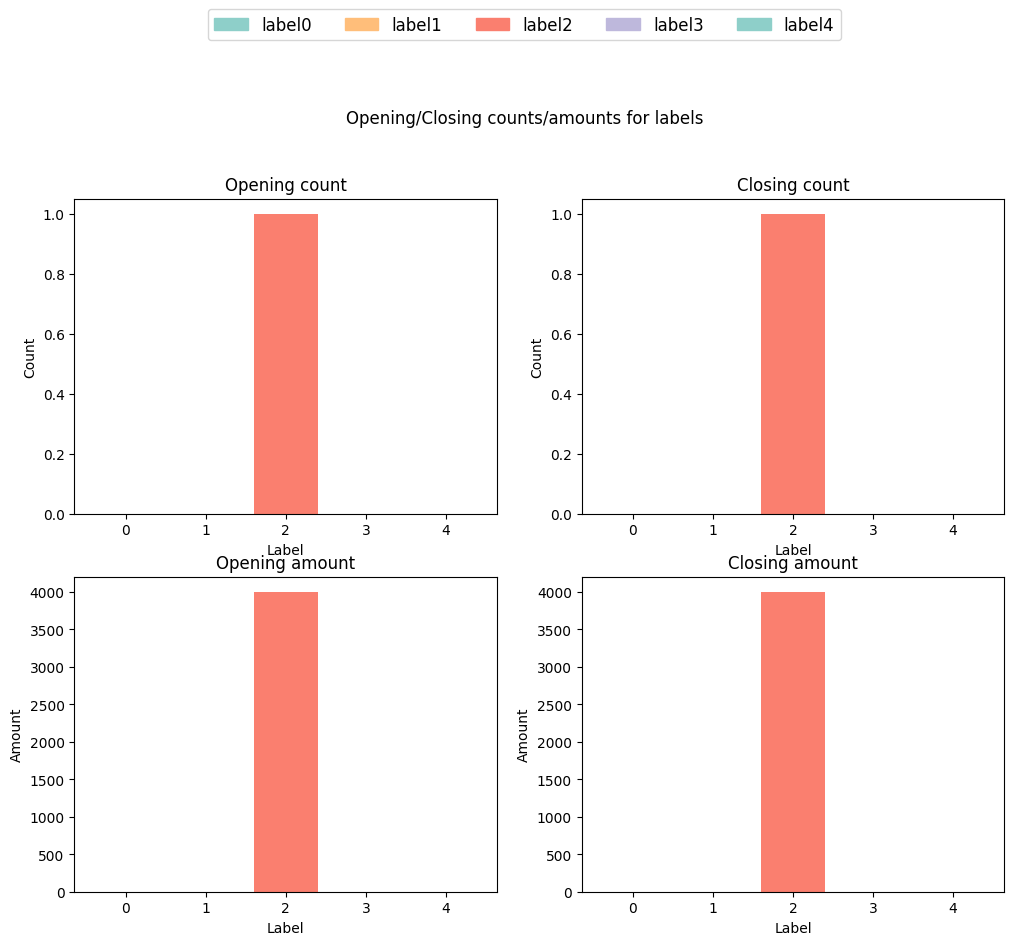

In [16]:
# Pass the x and y cordinates of the bars to the
# function. The label argument gives a label to the data.

fig = plt.figure(figsize=(12,9))
plt.suptitle('Opening/Closing counts/amounts for labels')


color_list = ["#8ECFC9", "#FFBE7A", "#FA7F6F", "#BEB8DC", "#8ECFC9"]
x_label = ["label0", "label1", "label2", "label3","label4"]

patches = [
    mpatches.Patch(color=color_list[i], label="{:s}".format(x_label[i]))
    for i in range(len(color_list))
]

ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width , box.height* 0.75])
fig.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=5, fontsize='large')

plt.subplot(221)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Opening count')
plt.bar([0,1,2,3,4],opening_count, label="Label",color = color_list)

plt.subplot(222)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Closing count')
plt.bar([0,1,2,3,4],opening_count, label="Label",color = color_list)


plt.subplot(223)
plt.xlabel('Label')
plt.ylabel('Amount')
plt.title('Opening amount')
plt.bar([0,1,2,3,4],opening_amount, label="Label",color = color_list)

plt.subplot(224)
plt.xlabel('Label')
plt.ylabel('Amount')
plt.title('Closing amount')
plt.bar([0,1,2,3,4], closing_amount, label="Label",color = color_list)

plt.savefig("../data_test/market_trend_freq.pdf",bbox_inches='tight')
plt.show()

In [17]:
# color_list = ["#8ECFC9", "#FFBE7A", "#FA7F6F", "#BEB8DC", "#8ECFC9"]
# x_label = ["label0", "label1", "label2", "label3","label4"]

# import matplotlib.patches as mpatches

# plt.figure(figsize=(10, 7))
# plt.xticks([1,2,3,4,5], x_label, fontsize="x-large")
# plt.ylabel("Amount", fontsize="x-large")
# plt.xlabel("Labels", fontsize="x-large")

# patches = [
#     mpatches.Patch(color=color_list[i])
#     for i in range(len(color_list))
# ]
# ax = plt.gca()
# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width , box.height* 0.75])
# ax.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=4, fontsize='large')

# for x,y in enumerate(opening_amount):
#     plt.text(x, y,"test",ha='center',fontsize=9)

# # plt.tight_layout()
# plt.savefig("../data_test/market_trend_freq.pdf",bbox_inches='tight')
# plt.show()

In [140]:
def analysis_along_time_dynamics(
    path, num_dynamics, num_seg, selected_timestamp: list
):
    # TODO 给定段时间，先把这段时间内的市场状态划分成num_dynamics个市场状态
    # TODO 根据策略 用开平仓的次数来划分时间（总开平仓次数）
    # TODO 两维度从时间和市场状态 计算胜率，收益率，持仓时间，最大回撤，calmar ratio，已经开仓量和平仓量占总开仓量和平仓量的百分比
    
    selected_market = data[
        (data["timestamp"] >= selected_timestamp[0])
        & (data["timestamp"] <= selected_timestamp[1])
    ]
    
    model = Linear_Market_Dynamics_Model(
        data=selected_market.reset_index(), dynamic_number=num_dynamics
    )
    model.run(path)
    df_label = pd.read_feather(path + "/df_label.feather")
    assert len(selected_market) == len(df_label)
    
    df_label = pd.read_feather(path + "/df_label.feather")
    
    opening_count_seg = [[0]*num_dynamics]*num_seg
    closing_count_seg = [[0]*num_dynamics]*num_seg
    opening_amount_seg = [[0]*num_dynamics]*num_seg
    closing_amount_seg = [[0]*num_dynamics]*num_seg
        
    opening_strategy_timestamp_list = []
    closing_strategy_timestamp_list = []

    for stack_order in strategy:                        # self.
        if stack_order["action"] == "buy":
            order_size = 0
            for order in stack_order["order"]:
                order_size += order["amount"]
            if order_size == stack_order["position"]:
                opening_strategy_timestamp_list.append(stack_order["timestamp"])
        elif stack_order["action"] == "sell":
            if stack_order["position"] == 0:
                closing_strategy_timestamp_list.append(stack_order["timestamp"])
    assert len(opening_strategy_timestamp_list) == len(
        closing_strategy_timestamp_list
    )
    # print(len(opening_strategy_timestamp_list))
    assert len(opening_strategy_timestamp_list) >= num_seg
    num_trade_seg = int(len(opening_strategy_timestamp_list) / num_seg)
    
    
    def calculate(local_selected_timestamp):
        tr, mdd, cr = calculate_metric(local_selected_timestamp)      #self.calculate_metric
        print()
        print(
            "in the {}th segment, the total return rate is {}, the max drawdown is {}, the calmar ratio is {}".format(
                i, tr, mdd, cr
            )
        )
        print()
        
    def along_dynamics(local_selected_timestamp,index_seg):
        selected_market = data[
            (data["timestamp"] >= local_selected_timestamp[0])
            & (data["timestamp"] <= local_selected_timestamp[1])
        ]
        selected_strategy = [  # 进行交易的market time
            item
            for item in strategy
            if local_selected_timestamp[0] <= item["timestamp"] <= local_selected_timestamp[1]
        ]
                
        opening_strategy_timestamp_list = []
        closing_strategy_timestamp_list = []
        opening_count = [0]*5
        closing_count = [0]*5
        opening_amount = [0]*5
        closing_amount = [0]*5
        
        for stack_order in selected_strategy:
            # print(stack_order)
            if stack_order["action"] == "buy":
                order_size = 0
                for order in stack_order["order"]:
                    order_size += order["amount"]
                label_index = df_label[df_label['timestamp'] == stack_order['timestamp']]['label'].values[0]    # 获取label
                opening_amount[label_index] +=  sum( level['amount'] for level in stack_order['order']) # 记录开仓总量至对应label
                if order_size == stack_order["position"]: 
                    # print(stack_order["timestamp"])
                    opening_strategy_timestamp_list.append(stack_order["timestamp"]) 
                    opening_count[label_index] += 1         # 记录对应label的开仓次数
                    # print("add buy count {} for label {}".format(opening_count[label_index], label_index))                    
                # sumtemp = sum( level['amount'] for level in stack_order['order'])
                # print("add buy amount {} for label {}".format(sumtemp, label_index))
                    
            elif stack_order["action"] == "sell":
                label_index = df_label[df_label['timestamp'] == stack_order['timestamp']]['label'].values[0]
                closing_amount[label_index] +=  sum( level['amount'] for level in stack_order['order'])   
                if stack_order["position"] == 0:
                    # print(stack_order["timestamp"])
                    closing_strategy_timestamp_list.append(stack_order["timestamp"])
                    closing_count[label_index] += 1
                    # print("add sell count {} for label {}".format(closing_count[label_index], label_index))                    
                # sumtemp = sum( level['amount'] for level in stack_order['order'])
                # print("add sell record {} for label {}".format(sumtemp, label_index))  
                
        opening_count_seg[index_seg] = opening_count
        closing_count_seg[index_seg] = closing_count
        opening_amount_seg[index_seg] = opening_amount
        closing_amount_seg[index_seg] = closing_amount
        
        
    for i in range(num_seg):
        # print()
        # print("this is segment {}".format(i))
        start_market_time = 0
        if i == 0:
            start_market_time = opening_strategy_timestamp_list[num_trade_seg * 0]
        else:
            for row_index, row in data.iterrows():  
                if row["timestamp"] > closing_strategy_timestamp_list[num_trade_seg * i]:
                    start_market_time = row["timestamp"]
                    break
           
        if i == num_seg - 1:
            close_market_time = closing_strategy_timestamp_list[-1]
        else:
            close_market_time = closing_strategy_timestamp_list[num_trade_seg * (i + 1)]

        phase_selected_timestamp = [start_market_time,close_market_time]
        calculate(phase_selected_timestamp)                
        along_dynamics(phase_selected_timestamp, i)    
        
    opening_count_perc = [ [float(format(x/sum(opening_count),'.2f')) for x in opening_count] for opening_count in opening_count_seg]         
    closing_count_perc = [ [float(format(x/sum(closing_count),'.2f')) for x in closing_count] for closing_count in closing_count_seg]
    opening_amount_perc = [ [float(format(x/sum(opening_amount),'.2f')) for x in opening_amount] for opening_amount in opening_amount_seg] 
    closing_amount_perc = [ [float(format(x/sum(closing_amount),'.2f')) for x in closing_amount] for closing_amount in closing_amount_seg]  

    
    return opening_count_seg,closing_count_seg,opening_amount_seg,closing_amount_seg
        
num_seg = 5        
selected_timestamp = [
    pd.Timestamp("2022-08-06 19:24:12"),
    pd.Timestamp("2022-08-15 23:59:59"),
]
num_dynamics = 5            
path = "../data/test2"
opening_count_seg,closing_count_seg,opening_amount_seg,closing_amount_seg = analysis_along_time_dynamics(path,num_dynamics,num_seg,selected_timestamp)
print("opening_count_seg", opening_count_seg)
print("closing_count_seg", closing_count_seg)
print("opening_amount_seg", opening_amount_seg)
print("closing_amount_seg", closing_amount_seg)

TypeError: list indices must be integers or slices, not str

In [80]:
opening_count_perc = [ [float(format(x/sum(opening_count),'.2f')) for x in opening_count] for opening_count in opening_count_seg]         
closing_count_perc = [ [float(format(x/sum(closing_count),'.2f')) for x in closing_count] for closing_count in closing_count_seg]
opening_amount_perc = [ [float(format(x/sum(opening_amount),'.2f')) for x in opening_amount] for opening_amount in opening_amount_seg] 
closing_amount_perc = [ [float(format(x/sum(closing_amount),'.2f')) for x in closing_amount] for closing_amount in closing_amount_seg]   
print("opening_count_perc", opening_count_perc)
print("closing_count_perc", closing_count_perc)
print("opening_amount_perc", opening_amount_perc)
print("closing_amount_perc", closing_amount_perc)

opening_count_perc [[0.0, 0.0, 0.56, 0.33, 0.11], [0.0, 0.12, 0.25, 0.25, 0.38], [0.0, 0.25, 0.5, 0.12, 0.12], [0.0, 0.12, 0.25, 0.62, 0.0], [0.0, 0.27, 0.09, 0.18, 0.45]]
closing_count_perc [[0.22, 0.0, 0.78, 0.0, 0.0], [0.12, 0.0, 0.62, 0.12, 0.12], [0.12, 0.12, 0.5, 0.25, 0.0], [0.12, 0.12, 0.38, 0.25, 0.12], [0.36, 0.0, 0.09, 0.36, 0.18]]
opening_amount_perc [[0.0, 0.07, 0.66, 0.21, 0.07], [0.04, 0.2, 0.32, 0.2, 0.24], [0.0, 0.24, 0.61, 0.08, 0.07], [0.0, 0.2, 0.39, 0.41, 0.0], [0.08, 0.36, 0.14, 0.14, 0.29]]
closing_amount_perc [[0.13, 0.07, 0.79, 0.02, 0.0], [0.06, 0.26, 0.48, 0.12, 0.08], [0.07, 0.17, 0.61, 0.15, 0.0], [0.08, 0.22, 0.41, 0.14, 0.14], [0.36, 0.17, 0.14, 0.22, 0.12]]


/tmp/ipykernel_2864135/4290579333.py:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(221)


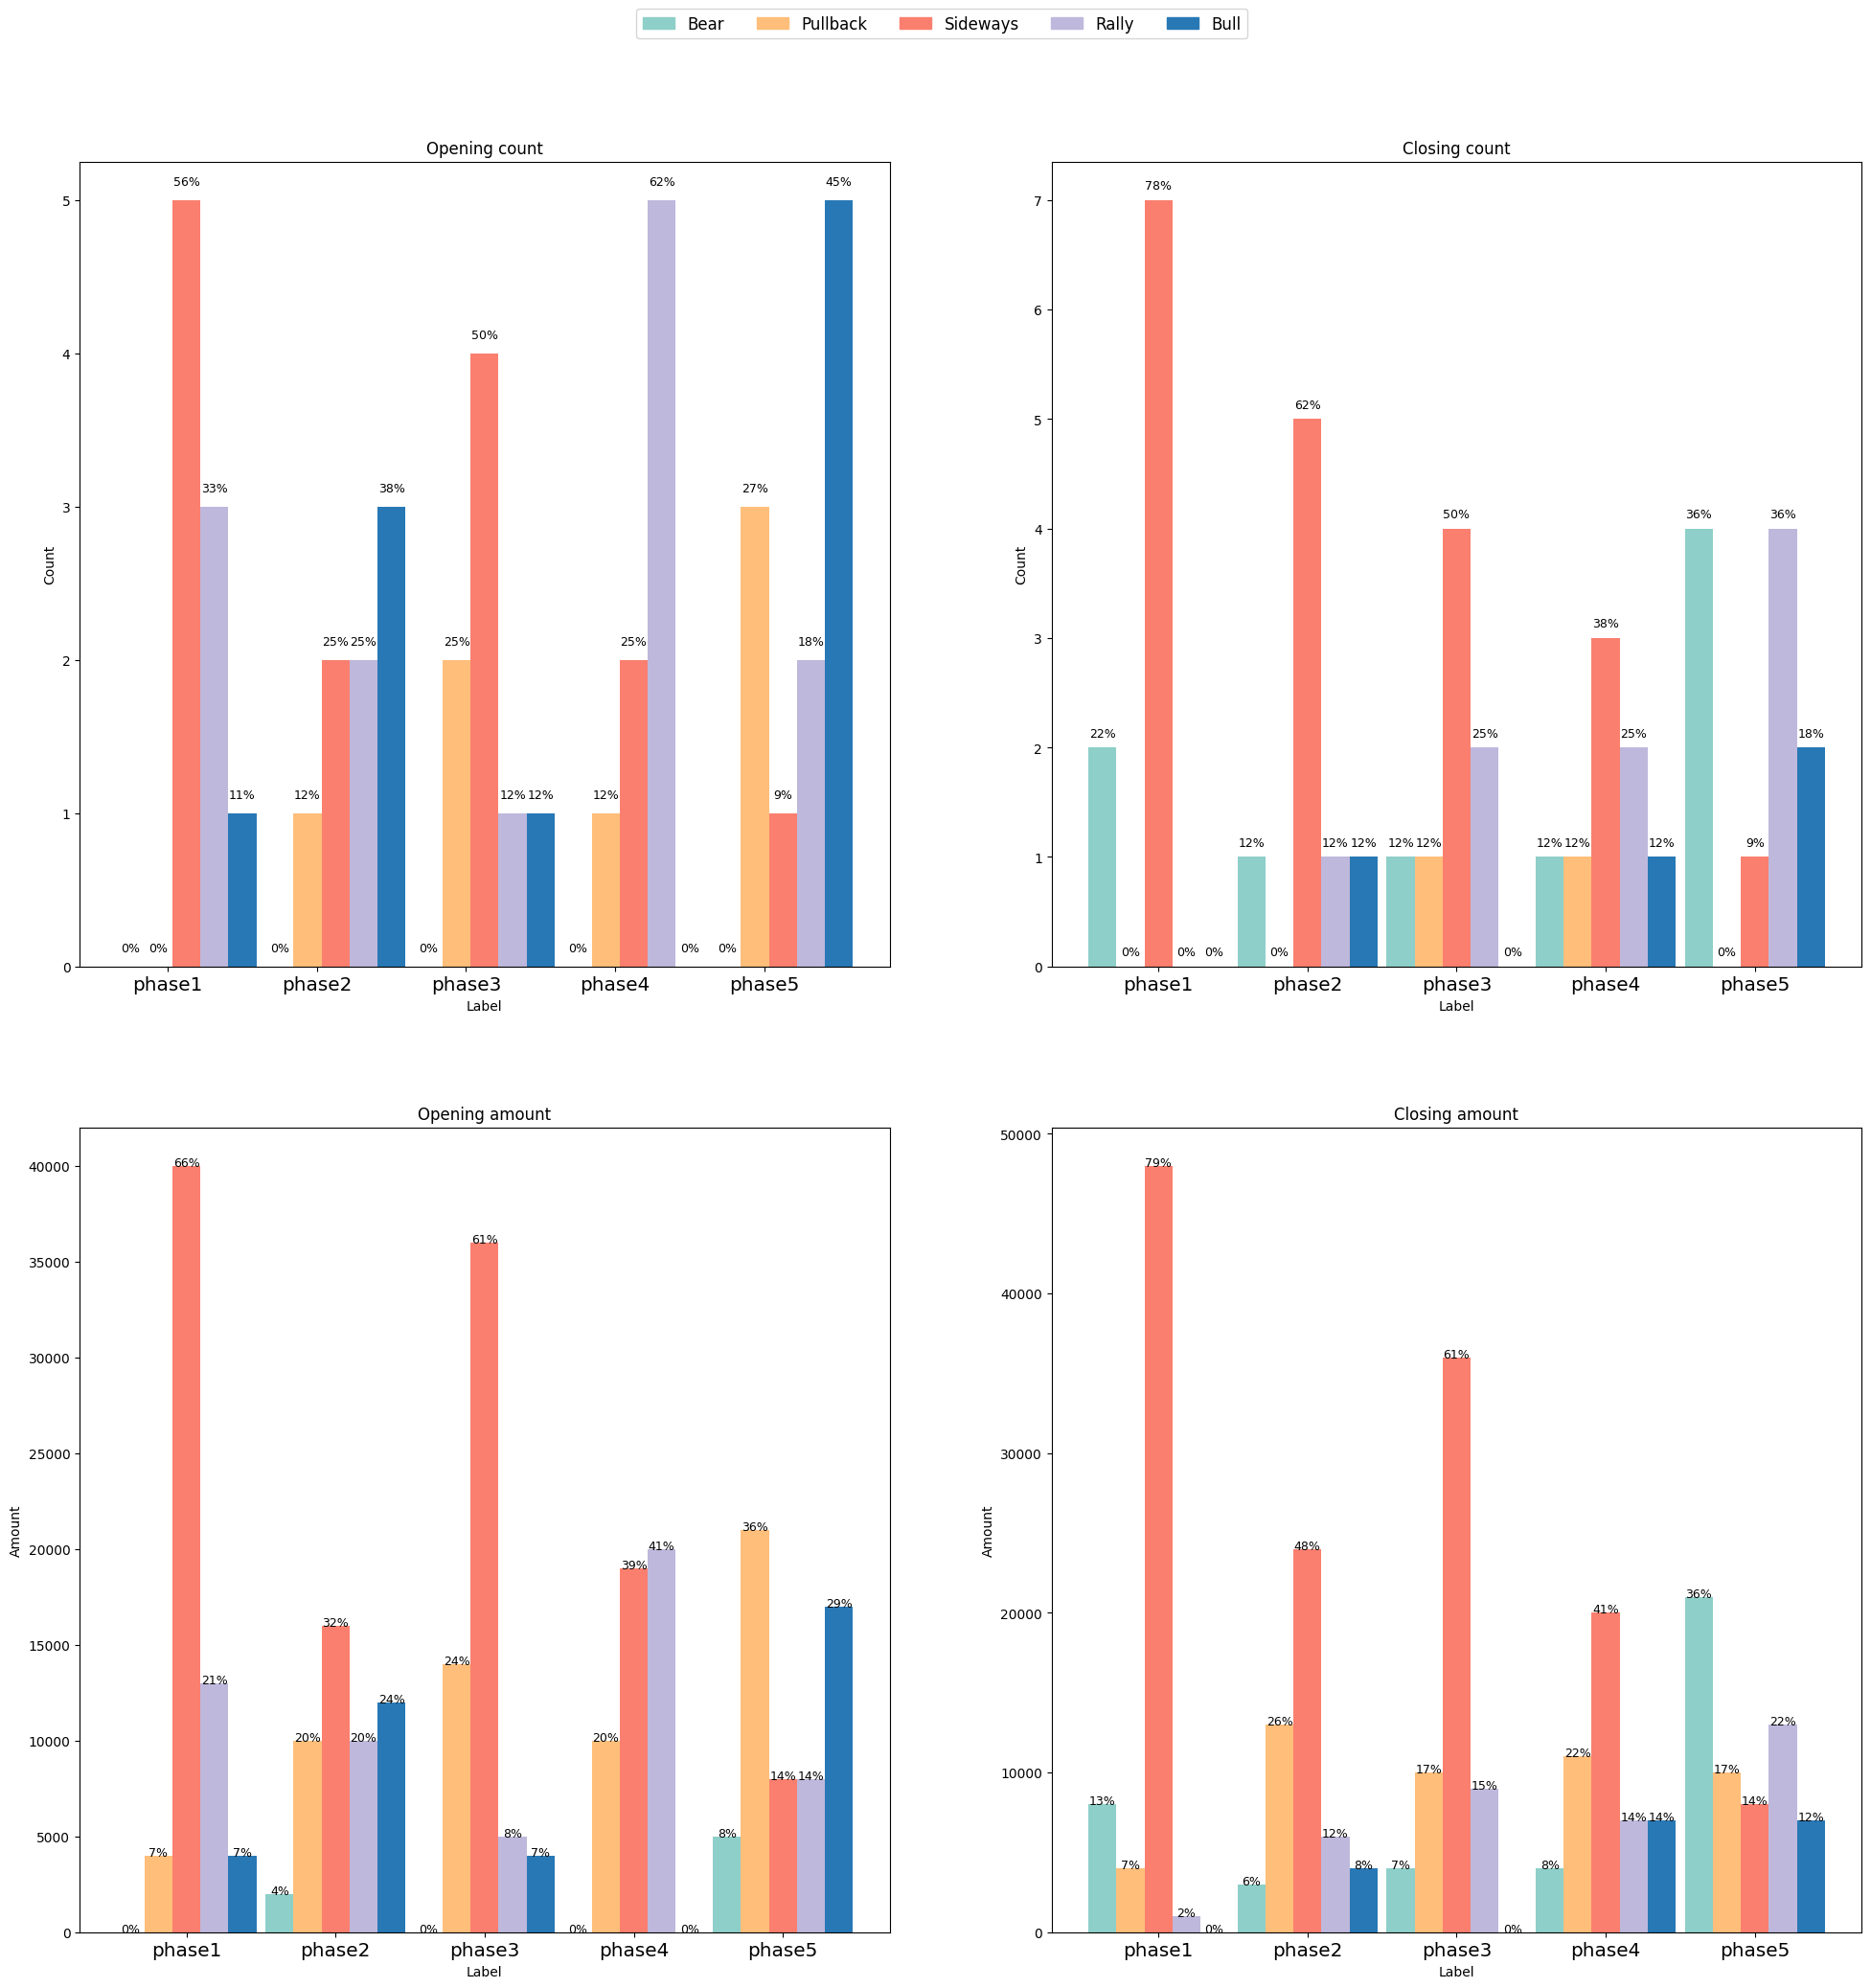

In [143]:
color_list = ["#8ECFC9", "#FFBE7A", "#FA7F6F", "#BEB8DC", "#2878B5"]
x_label = ["phase1","phase2","phase3","phase4","phase5"]
y_label = ["Bull", "Rally", "Sideways", "Pullback", "Bear"]
y_label.reverse()


x_ax = np.array(range(len(x_label)))*4

fig = plt.figure(figsize=(24,24))
# plt.suptitle('Opening/Closing counts/amounts along different time with diff market type')

patches = [
    mpatches.Patch(color=color_list[i], label="{:s}".format(y_label[i]))
    for i in range(len(color_list))
]

ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width , box.height* 0.75])
fig.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=5, fontsize='large')

plt.subplot(221)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Opening count')
for i in range(5):
    plt.bar(
        [m + i * 0.75 for m in x_ax],
        [count[i] for count in opening_count_seg],
        label=y_label[i],
        width=0.75,
        color=color_list[i],
    )
plt.xticks([i + 1 for i in x_ax], x_label, fontsize="x-large")
for i in range(len(opening_count_seg)):
    data=[count[i] for count in opening_count_seg]
    for x,y in enumerate(data):
        plt.text(x*4+i*0.75, y+0.1,  format(opening_count_perc[x][i]*100,'.0f') + "%",ha='center',fontsize=9)
 
plt.subplot(222)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Closing count')
for i in range(5):
    plt.bar(
        [m + i * 0.75 for m in x_ax],
        [count[i] for count in closing_count_seg],
        label=y_label[i],
        width=0.75,
        color=color_list[i],
    )
plt.xticks([i + 1.5 for i in x_ax], x_label, fontsize="x-large")
for i in range(len(closing_count_seg)):
    data=[count[i] for count in closing_count_seg]
    for x,y in enumerate(data):
        plt.text(x*4+i*0.75, y+0.1, format(closing_count_perc[x][i]*100,'.0f') + "%",ha='center',fontsize=9)
        
plt.subplot(223)
plt.xlabel('Label')
plt.ylabel('Amount')
plt.title('Opening amount')
for i in range(5):
    plt.bar(
        [m + i * 0.75 for m in x_ax],
        [count[i] for count in opening_amount_seg],
        label=y_label[i],
        width=0.75,
        color=color_list[i],
    )
plt.xticks([i + 1.5 for i in x_ax], x_label, fontsize="x-large")
for i in range(len(opening_amount_seg)):
    data=[count[i] for count in opening_amount_seg]
    for x,y in enumerate(data):
        plt.text(x*4+i*0.75, y+0.1, format(opening_amount_perc[x][i]*100,'.0f') + "%",ha='center',fontsize=9)
         
plt.subplot(224)
plt.xlabel('Label')
plt.ylabel('Amount')
plt.title('Closing amount')
for i in range(5):
    plt.bar(
        [m + i * 0.75 for m in x_ax],
        [count[i] for count in closing_amount_seg],
        label=y_label[i],
        width=0.75,
        color=color_list[i],
    )
plt.xticks([i + 1.5 for i in x_ax], x_label, fontsize="x-large")
for i in range(len(closing_amount_seg)):
    plotdata=[count[i] for count in closing_amount_seg]
    for x,y in enumerate(plotdata):
        plt.text(x*4+i*0.75, y+0.1, format(closing_amount_perc[x][i]*100,'.0f') + "%"  ,ha='center',fontsize=9)

# img_path = path + "/time_dynamics_proportion.pdf"        
# plt.savefig(img_path,bbox_inches='tight')
        
plt.savefig("../data_test/market_trend_freq.pdf",bbox_inches='tight')
plt.show()

In [ ]:
analyzer = Analyzer(data, strategy)
time_analysis = analyzer.analysis_along_time(1)
mean_return_rate, mean_duration, mean_mdd = analyzer.analysis_behavior(
    analyzer.strategy
)
print("mean_return_rate", mean_return_rate)
print("mean_duration", mean_duration)
print("mean_mdd", mean_mdd)

In [3]:
import pandas as pd
import numpy as np

In [6]:
df=pd.read_feather("/home/mlqin/lxy/Evaluation/data_test/df_label.feather")
df.timestamp.unique().tolist()

[Timestamp('2022-08-06 21:26:56'),
 Timestamp('2022-08-06 21:26:57'),
 Timestamp('2022-08-06 21:26:58'),
 Timestamp('2022-08-06 21:26:59'),
 Timestamp('2022-08-06 21:27:00'),
 Timestamp('2022-08-06 21:27:01'),
 Timestamp('2022-08-06 21:27:02'),
 Timestamp('2022-08-06 21:27:03'),
 Timestamp('2022-08-06 21:27:04'),
 Timestamp('2022-08-06 21:27:05'),
 Timestamp('2022-08-06 21:27:06'),
 Timestamp('2022-08-06 21:27:07'),
 Timestamp('2022-08-06 21:27:08'),
 Timestamp('2022-08-06 21:27:09'),
 Timestamp('2022-08-06 21:27:10'),
 Timestamp('2022-08-06 21:27:11'),
 Timestamp('2022-08-06 21:27:12'),
 Timestamp('2022-08-06 21:27:13'),
 Timestamp('2022-08-06 21:27:14'),
 Timestamp('2022-08-06 21:27:15'),
 Timestamp('2022-08-06 21:27:16'),
 Timestamp('2022-08-06 21:27:17'),
 Timestamp('2022-08-06 21:27:18'),
 Timestamp('2022-08-06 21:27:19'),
 Timestamp('2022-08-06 21:27:20'),
 Timestamp('2022-08-06 21:27:21'),
 Timestamp('2022-08-06 21:27:22'),
 Timestamp('2022-08-06 21:27:23'),
 Timestamp('2022-08-

In [1]:
position_market_record=[0,1,2,3]
selected_market_price=[10,2,3,5]

position_value_record = [
            position * single_value
            for position, single_value in zip(
                position_market_record, selected_market_price
            )
        ]
position_value_record

[0, 2, 6, 15]